In [1]:
import torch
from models import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_lenght": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]    # crop current context if it exceeds the supported size
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]   # focus only on last time step so that (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

1. Prepare functions for generating text

In [2]:
import tiktoken

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")
start_context = "Every effort moves you"

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add the batch dimensionality
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    decoded = tokenizer.decode(flat.tolist())
    return decoded

In [4]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_lenght"]
)

token_ids_to_text(token_ids, tokenizer)

'Every effort moves you rentingノJohnIncvertSw440 Lead nylon>>>>'

2. Loss

In [5]:
inputs = torch.tensor([[16833, 3626, 6100],     # Every effort moves
                       [40, 1107, 588]])        # I really like

targets = torch.tensor([[3626, 6100, 345],      # effort moves you
                        [1107, 588, 11311]])    # really like chocolate

In [6]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
probas.shape
# 2,    - batches
# 3,    - tokens
# 50257 - embedding dim

torch.Size([2, 3, 50257])

In [7]:
max(probas[0][2])

tensor(0.0002)

In [8]:
probas[0][2][44376]

tensor(0.0002)

In [9]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
token_ids

tensor([[[16657],
         [16031],
         [44376]],

        [[49906],
         [29669],
         [ 6972]]])

In [10]:
targets[0]
probas[0, [0,1,2], targets[0]]

tensor([7.2671e-05, 3.1283e-05, 1.2676e-05])

In [11]:
print(f"Target batch 1: {token_ids_to_text(targets[0], tokenizer)}     -> {targets[0]}    -> {probas[0, [0,1,2], targets[0]]}")
print(f"Output batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)} -> {token_ids[0].flatten()} -> {probas[0, [0,1,2], token_ids[0].flatten()]}")
target_probas_1 = probas[0, [0,1,2], targets[0]]

Target batch 1:  effort moves you     -> tensor([3626, 6100,  345])    -> tensor([7.2671e-05, 3.1283e-05, 1.2676e-05])
Output batch 1:  Armed saves inaction -> tensor([16657, 16031, 44376]) -> tensor([0.0002, 0.0002, 0.0002])


In [12]:
print(f"Target batch 2: {token_ids_to_text(targets[1], tokenizer)}    -> {targets[1]} -> {probas[1, [0,1,2], targets[1]]}")
print(f"Output batch 2: {token_ids_to_text(token_ids[1].flatten(), tokenizer)} -> {token_ids[1].flatten()} -> {probas[1, [0,1,2], token_ids[1].flatten()]}")
target_probas_2 = probas[1, [0,1,2], targets[1]]

Target batch 2:  really like chocolate    -> tensor([ 1107,   588, 11311]) -> tensor([1.0426e-05, 5.2505e-05, 5.1900e-06])
Output batch 2:  pressuring empoweredowed -> tensor([49906, 29669,  6972]) -> tensor([0.0002, 0.0002, 0.0002])


In [13]:
probas[
    0,          # batch number
    [0, 1, 2],  # for all 3 token embeddings 
    345         # get the one with id 345
    ]


tensor([1.8436e-05, 2.6831e-05, 1.2676e-05])

In [14]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))   # log probability
print(log_probas)
avg_log_probas = torch.mean(log_probas)                                 # average log probability
print(avg_log_probas)
neg_avg_log_probas = -avg_log_probas                                    # negative average log probability == cross entropy loss
print(neg_avg_log_probas)

tensor([ -9.5296, -10.3724, -11.2758, -11.4712,  -9.8546, -12.1688])
tensor(-10.7787)
tensor(10.7787)


In [15]:
# In pytorch:

print(f"Logits shape: {logits.shape}")
print(f"Targets shape: {targets.shape}")


logits = logits.flatten(0,1)            # needs to flatten so they have common dimension
targets = targets.flatten(0,1)

print(f"Logits shape: {logits.shape}")
print(f"Targets shape: {targets.shape}")

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Logits shape: torch.Size([6, 50257])
Targets shape: torch.Size([6])


In [16]:
cross_entropy_loss = torch.nn.functional.cross_entropy(logits, targets)
cross_entropy_loss

tensor(10.7787)

In [17]:
perplexity = torch.exp(cross_entropy_loss)
perplexity  # model was not sure which token to pick from about 47,989 tokens in vocabulary

tensor(47989.2031)

In [18]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(f"Total number of characters: {total_characters}")
print(f"Total number of tokens: {total_tokens}")

Total number of characters: 20479
Total number of tokens: 5145


In [19]:
# split the text into training and validation sets,
# tokenize text,
# divide tokenized text into chunks,
# shuffle the rows in dataset

train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [20]:
from dataloader import create_dataloader_v1

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_lenght=GPT_CONFIG_124M["context_lenght"],
    stride=GPT_CONFIG_124M["context_lenght"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_lenght=GPT_CONFIG_124M["context_lenght"],
    stride=GPT_CONFIG_124M["context_lenght"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [21]:
print("Train loader:")
for i, (x, y) in enumerate(train_loader, start=1):
    print(f"Training batch {i}: {x.shape, y.shape}")

print("Val loader:")
for i, (x, y) in enumerate(val_loader, start=1):
    print(f"Val batch {i}: {x.shape, y.shape}")

Train loader:
Training batch 1: (torch.Size([2, 256]), torch.Size([2, 256]))
Training batch 2: (torch.Size([2, 256]), torch.Size([2, 256]))
Training batch 3: (torch.Size([2, 256]), torch.Size([2, 256]))
Training batch 4: (torch.Size([2, 256]), torch.Size([2, 256]))
Training batch 5: (torch.Size([2, 256]), torch.Size([2, 256]))
Training batch 6: (torch.Size([2, 256]), torch.Size([2, 256]))
Training batch 7: (torch.Size([2, 256]), torch.Size([2, 256]))
Training batch 8: (torch.Size([2, 256]), torch.Size([2, 256]))
Training batch 9: (torch.Size([2, 256]), torch.Size([2, 256]))
Val loader:
Val batch 1: (torch.Size([2, 256]), torch.Size([2, 256]))


In [22]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)    # this allows to use GPU
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)  # iterate over all batches if num_batches is not specified
    else:
        num_batches = min(num_batches, len(data_loader))    # reduce number of batches to match total number of batches in data loader 
                                                            # if num_batches exceeds the number of batches in data loader
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break
    return total_loss / num_batches



In [27]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"Training loss: {train_loss}")
print(f"Validation loss: {val_loss}")

Training loss: 10.990399360656738
Validation loss: 10.976140022277832


In [28]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, encoded, 50, context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()     # calculate gradients
            optimizer.step()    # update weights based on gradients
            tokens_seen += input_batch.numel()
            global_step += 1


            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Ep {epoch+1} (Step {global_step:06d}):"
                      f"Train loss {train_loss:.3f}"
                      f"Val loss {val_loss:.3f}"
                      )
            generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.0004, weight_decay=0.1
)
start_context = "Every effort moves you"
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5, start_context=start_context, tokenizer=tokenizer, 
)

Ep 1 (Step 000000):Train loss 9.766Val loss 9.897
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Every effort moves you,.                                                
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Ep 1 (Step 000005):Train loss 8.056Val loss 8.332
Every effort moves you, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Every effort moves you, the,, the the the the the the the the the the the the the, the the the the the the, the the the the the the the the the the the the the the the the the the the the the the the the the
Every effort moves you,,,,,,,,,,,,,,.                                   
Every effort moves you,,,,,,,,,

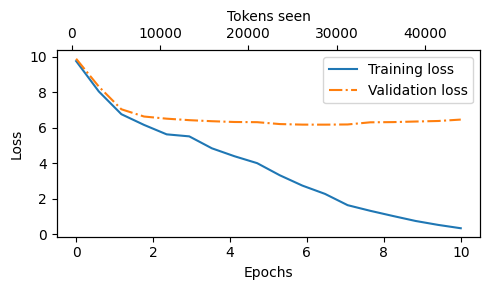

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, traini_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [39]:
model.to("cpu")
model.eval()
tokenizer=tiktoken.get_encoding("gpt2")
context_input = "Tell me, who are you?"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(context_input, tokenizer),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_lenght"]
)
print(token_ids_to_text(token_ids, tokenizer))

Tell me, who are you? on--forming, as it were, so inevitably the background of her own picture--had lent herself in an unusual degree to the display of this false virtuosity. The picture was one of Jack's "strongest," as his own trade hardly
